Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:


In [15]:
NAME = "Piotr Durniat"

---


# 3. Grupowo ekwiwariantne sieci konwolucyjne

Ostatnią architekturą, którą dzisiaj sprawdzimy są tzw. _Group Equivariant Neural Networks_, czyli sieci neuronowe (w naszym przypadku konwolucyjne), które opisują funkcje ekwiwariantne względem określonej grupy symetrii. Po raz pierwszy koncepcja takich sieci została opisana w 2016 r. przez Cohena i Wellinga w pracy [Group Equivariant Convolutional Networks](https://arxiv.org/pdf/1602.07576.pdf). W pracy formalizują zastosowanie grup symetrii do modelowania struktury danych – dokładniej mówiąc rozważają dwie grupy: _p4_ (obroty o 90 stopni) oraz _p4m_ (obroty o 90 stopni i odbicia).

Implementacja grupowo ekwiwariantnych sieci jest zadaniem nietrywialnym i czasochłonnym, stąd w tym zeszycie wykorzystamy bibliotekę `e2cnn`, która posiada zaimplementowane warstwy grupowo ekwiwariantne.


In [16]:
import torch

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(42)

## 3.1. Architektura

Założeniem modelu będzie, aby koder był w stanie stworzyć niezmienniczą (ang. _invariant_) reprezentację podstawowych i obróconych obrazów wejściowych. Moduł dekodera nie będziemy modyfikować i użyjemy klasy `CNNDecoder` z poprzedniego zeszytu.


## Zadanie 3.1. (4 pkt)

W celu zrozumienia grupowo ekwiwariantnych sieci zaleca się zapoznanie z poniższymi materiałami:

- [2-częściowy blog na temat G-CNN](https://fabianfuchsml.github.io/equivariance1of2/)
- [Wykład Erika Bekkersa "Group Equivariant Deep Learning (UvA - 2022)" (Lecture 1.1-1.7)](https://youtube.com/playlist?list=PL8FnQMH2k7jzPrxqdYufoiYVHim8PyZWd)

Zapoznaj się z biblioteką E2CNN:

- [Przykład użycia](https://github.com/QUVA-Lab/e2cnn#getting-started)
- [Zeszyt wprowadzający](https://github.com/QUVA-Lab/e2cnn/blob/master/examples/introduction.ipynb)

i zaimplementuj moduł kodera z następującą architekturą:

- dla każdej warstwy konwolucji przymij takie same parametry jak dla `CNNEncoder` z poprzedniego zeszytu, tzn. `kernel_size=3`, `stride=2`, `padding=1`
- pierwsza warstwa konwolucji obrotowej `R2Conv` obliczająca 8 filtrów wyjściowych
- aktywacja ReLU
- druga warstwa konwolucji obrotowej `R2Conv` obliczająca 16 filtrów wyjściowych
- aktywacja ReLU
- trzecia warstwa konwolucji obrotowej `R2Conv` obliczająca 32 filtry wyjściowe
- redukacja maksymalizująca (`PointwiseMaxPoolAntialiased`) z kernelem o wymiarze `3`
- redukcja grupowa (`GroupPooling`)
- część wielowarstwowego perceptrona z modelu `CNNEncoder`, tzn.:
  - spłaszczenie macierzy do wektora,
  - warstwa liniowa z 128 cechami wyjściowymi
  - aktywacja ReLU
  - warstwa liniowa z `latent_dim` cechami wyjściowymi

Jako grupę symetrii przyjmij grupę obrotów dyskretnych, tzw. grupę cykliczną $C_N$ (`Rot2dOnR2`).

Pamiętaj użyciu właściwych modułów z pakietu `e2cnn.nn` oraz `torch.nn`.
**Pamiętaj, że opórcz zamplementowania modelu należy dobrze zapoznać się z teorią. Warto również zweryfikować, jakie są i do czego odnoszą się wymiary tensorów zwracanych przez każdą warstwę.**


In [17]:
from e2cnn import gspaces
from e2cnn import nn as enn
import torch.nn as nn


class GCNNEncoder(torch.nn.Module):

    def __init__(self, latent_dim: int, N: int):
        super().__init__()

        self.G = gspaces.Rot2dOnR2(N=N)

        self.feat_type_in = enn.FieldType(self.G, [self.G.trivial_repr])
        self.feat_type_hid_1 = enn.FieldType(self.G, 8 * [self.G.trivial_repr])
        self.feat_type_hid_2 = enn.FieldType(self.G, 16 * [self.G.trivial_repr])
        self.feat_type_out = enn.FieldType(self.G, 32 * [self.G.trivial_repr])

        self.layers = enn.SequentialModule(
            enn.R2Conv(
                self.feat_type_in,
                self.feat_type_hid_1,
                kernel_size=3,
                stride=2,
                padding=1,
            ),
            enn.ReLU(self.feat_type_hid_1, inplace=True),
            enn.R2Conv(
                self.feat_type_hid_1,
                self.feat_type_hid_2,
                kernel_size=3,
                stride=2,
                padding=1,
            ),
            enn.ReLU(self.feat_type_hid_2, inplace=True),
            enn.R2Conv(
                self.feat_type_hid_2,
                self.feat_type_out,
                kernel_size=3,
                stride=2,
                padding=1,
            ),
            enn.PointwiseMaxPoolAntialiased(in_type=self.feat_type_out, kernel_size=3),
            enn.GroupPooling(self.feat_type_out),
        )

        self.mlp = torch.nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, latent_dim),
        )

    def forward(self, img: torch.Tensor) -> torch.Tensor:

        img = enn.GeometricTensor(img, self.feat_type_in)
        x = self.layers(img)
        x = x.tensor
        x = self.mlp(x)
        return x

## 3.2. Uczenie modelu

W przeciwieństwie do poprzednich zeszytów, nie załączono wcześniej przygotowanego modelu, a uczenie należy przeprowadzić samemu. Uczenie powinno zająć kilkanaście/kilkadziesiąt minut, a w razie mocno ograniczonych zasobów należy skorzystać z Google Colab (aby wykorzystać GPU wystarczy przekazać odpowiedni parametr do `Trainer`, co jest opisane w dokumentacji: [Trainer API](https://lightning.ai/docs/pytorch/stable/common/trainer.html#trainer-class-api), [użycie GPU](https://lightning.ai/docs/pytorch/stable/accelerators/gpu_basic.html)).


In [18]:
LOG_PATH = "./data/GCNN/logs"
CHECKPOINT_PATH = "./data/GCNN/model.ckpt"

In [19]:
%load_ext tensorboard
%tensorboard --logdir $LOG_PATH --host 0.0.0.0 --port 6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 177045), started 0:00:59 ago. (Use '!kill 177045' to kill it.)

In [20]:
from src.dataset import SampledMNISTData
from src.ae import Autoencoder
from src.cnn import CNNDecoder

In [21]:
class GCNNAutoencoder(Autoencoder):

    def __init__(self, latent_dim: int):
        super().__init__(
            encoder=GCNNEncoder(latent_dim=latent_dim, N=8),
            decoder=CNNDecoder(latent_dim=latent_dim),
        )
        self.save_hyperparameters({"latent_dim": latent_dim})

In [29]:
import os
from lightning import Trainer
from lightning.pytorch.loggers import TensorBoardLogger
from src.dataset import SampledMNISTData


if os.path.isfile(CHECKPOINT_PATH):
    # if already trained, load saved checkpoint
    # it is normal that some parameters are missing (difference is due to eval and train modes)
    gcnn_ae = GCNNAutoencoder.load_from_checkpoint(
        CHECKPOINT_PATH, strict=False, map_location="cpu"
    )
else:
    # train model otherwise
    gcnn_ae = GCNNAutoencoder(latent_dim=2)
    trainer = Trainer(
        max_epochs=10,
        logger=TensorBoardLogger(
            save_dir=LOG_PATH, name="gcnn_ae", default_hp_metric=False
        ),
        callbacks=[],
        enable_checkpointing=False,
        accelerator="auto",
    )
    mnist = SampledMNISTData(num_samples_per_class=-1)

    trainer.fit(
        model=gcnn_ae,
        train_dataloaders=mnist,
    )

    trainer.save_checkpoint(filepath=CHECKPOINT_PATH)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type        | Params
-----------------------------------------
0 | _encoder | GCNNEncoder | 5.8 K 
1 | _decoder | CNNDecoder  | 43.4 K
-----------------------------------------
49.2 K    Trainable params
0         Non-trainable params
49.2 K    Total params
0.197     Total estimated model params size (MB)
/home/piotr/projects/ai/ur-l/l02-sr-17-piotrdurniat/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## 3.3. Badanie jakości reprezentacji w zadaniu


Wczytujemy losową próbkę zbioru danych MNIST:


In [30]:
mnist = SampledMNISTData(num_samples_per_class=100, seed=42)

Dla każdej próbki wyciągamy jej reprezentację (wektor dwu-wymiarowy) oraz etykietę:


In [31]:
from src.utils import extract_representations


representations = extract_representations(
    model=gcnn_ae,
    dataset=mnist,
)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [32]:
from src.utils import evaluate_linear


auc_train, auc_test = evaluate_linear(
    z_train=representations["train"]["z"],
    y_train=representations["train"]["y"],
    z_test=representations["test"]["z"],
    y_test=representations["test"]["y"],
)

print(f"AUC => train: {auc_train * 100.0:.2f} [%], test: {auc_test * 100.0:.2f} [%]")

AUC => train: 83.04 [%], test: 83.67 [%]


## 3.4. Wizualizacja przestrzeni reprezentacji


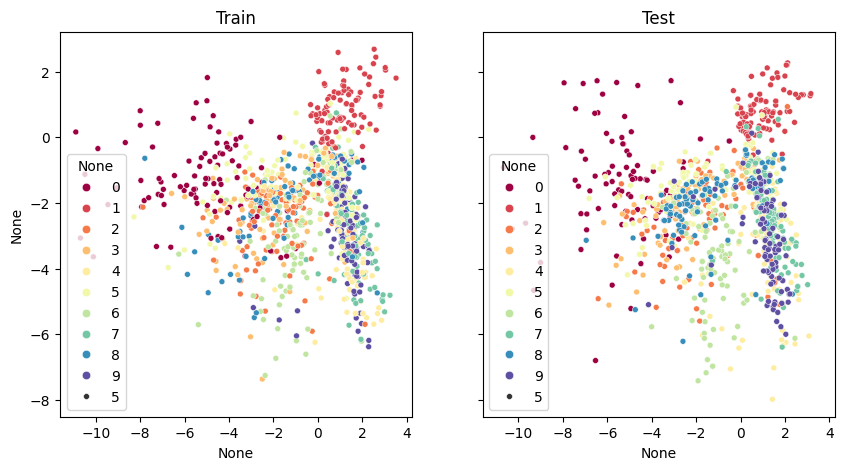

In [33]:
%matplotlib inline

from src.utils import visualize_latent_spaces


visualize_latent_spaces(representations)

## 3.5. Wizualizacja jakości rekonstrukcji


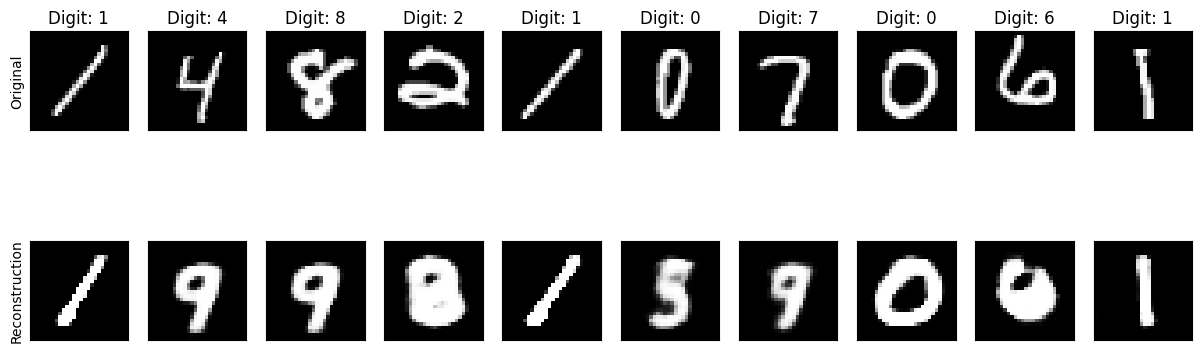

In [34]:
%matplotlib inline

from src.utils import visualize_random_sample

    
visualize_random_sample(model=gcnn_ae, dataset=mnist.mnist_train)

## 3.6. Odporność na obroty

Zbadamy jak się zachowuje model oparty o grupowo ekwiwariantne sieci konwolucyjne w przypadku obrotów.


Wybieramy dowolną instancję ze zbioru danych:


In [35]:
img, _ = mnist.mnist_train[256]

## Zadanie 3.3. (0 pkt)

Skopiuj implementację funkcji `rotate` z poprzedniego zeszytu.


In [36]:
import torch
import torchvision.transforms.functional as TF


def rotate(img: torch.Tensor, angle: float) -> torch.Tensor:
    pil_image = TF.to_pil_image(img, mode="F")
    rotated_pil_image = TF.rotate(pil_image, angle)
    rotated_tensor = TF.to_tensor(rotated_pil_image)
    rotated_tensor = rotated_tensor.squeeze(0)
    return rotated_tensor

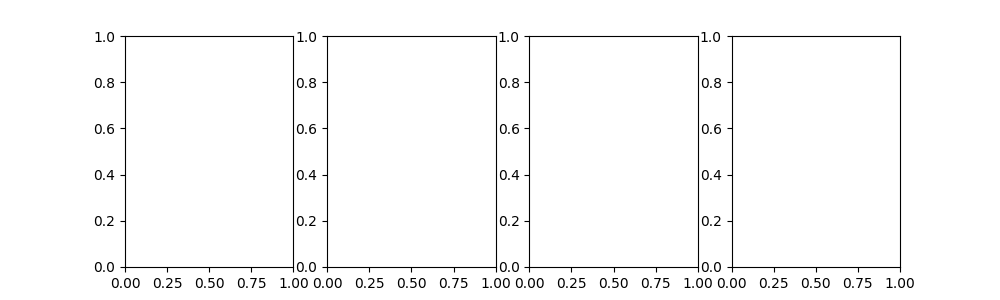

In [37]:
%matplotlib widget
from src.transforms import plot_transformation


plot_transformation(
    image=img,
    model=gcnn_ae,
    transformation_fn=rotate,
    min_param_value=0,
    max_param_value=360,
    step=45,
    keep_channel_dim=True,
)

## Zadanie 3.4 (1 pkt)

Czy autokoder G-CNN jest odporny na obroty obiektów? Z czego może to wynikać?


TU WPISZ ODPOWIEDŹ
